# Introduction
Here I will try more sophisticated techniques to work with imbalance datasets. Let us dive right into it! 

In [3]:
# new library!
#pip install imblearn

In [4]:
#pip install --upgrade scikit-learn imbalanced-learn

In [5]:
# import 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import scikitplot as skplt


# Let us have a clearer code
from utils import cleaning_data

In [6]:
import plotly.io as pio
import plotly.express as px

pio.renderers.default = "svg"

import os

In [7]:
# Here is the data: https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/input

X_full = pd.read_csv('creditcard.csv')


# Transported is the target, if there is no target eliminate row associated with it
column_to_predict = "Class"
# drop null in the column we are going to predict
X_full.dropna(axis=0, subset=[column_to_predict], inplace=True)

y = X_full[column_to_predict]
X = X_full.copy()
X.drop([column_to_predict], axis=1, inplace=True)

# notice we use stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                random_state=0,stratify=y) 

###################### this step is to simplify life later on ########################


In [8]:
def is_imba(y):
    df = pd.DataFrame({'categories':list(y.value_counts().index),
                    'counts':list(y.value_counts().values)})
    percentage_biggest_class = (df['counts'].max()/df['counts'].sum())*100
    print(f"we have {y.size} elements")
    print("")
    print(f"the biggest class has a {round(percentage_biggest_class,2)}% of all the samples in this dataset")
    fig = px.pie(df, values='counts', names='categories', title='Categories in the target values')
    fig.show()
    if percentage_biggest_class>90:
        return print("This class is clearly imbalanced")
    else: 
        return print("This class doesn't look like imbalanced, please make sure looking the graph")
    

we have 227845 elements

the biggest class has a 99.83% of all the samples in this dataset


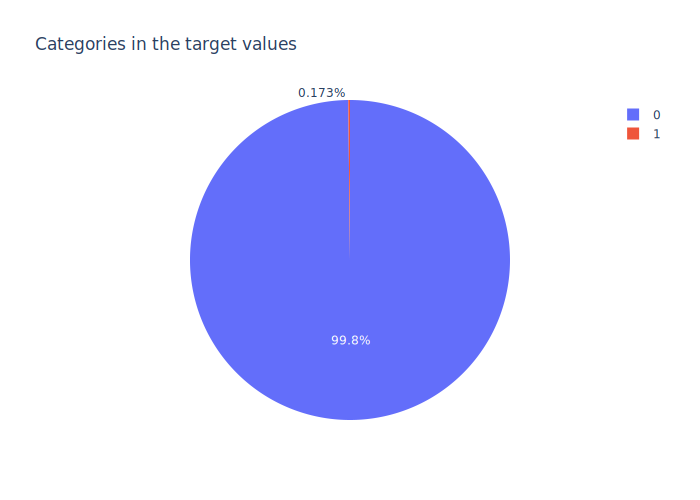

This class is clearly imbalanced


In [9]:
is_imba(y_train)

In [10]:
from imblearn.under_sampling import NearMiss
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

This is a naive approach, with better techniques of under-over sampling. The problem that it has is that we use method of oversampling and undersampling without considering better approaches and pipeline already created that have better "sync" between each other.

In [11]:
def fit_model(X,y,X_test=False,
             # near_miss undersampling technique
             version=1, n_neighbors_near_miss=3, sampling_strategy=0.1,
             cv=3,n_jobs=-1,scoring='accuracy',
             max_depth=10,n_estimators=344,n_neighbors=5,thr=0.5,sample_weight=None ):

    # We are gonna use a cross validation now
    
    """
    best model so far is: 
    {'model__max_depth': 10,
    'model__n_estimators': 344,
    'preprocessor__numerical_transformer__imputer__n_neighbors': 5}
    
    
    """

    nm = NearMiss(sampling_strategy=sampling_strategy,version=version, n_neighbors=n_neighbors)
    # I do not want to play much with SMOTE
    over = SMOTE(sampling_strategy = 1)
    steps = [('under', nm),('over', over)]
    pipeline = Pipeline(steps=steps)
    X, y = pipeline.fit_resample(X, y)

    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
    numerical_col_imputed = [col for col in numerical_col if X[col].isnull().any()==True]

    categorical_col = [col for col in X.columns if str(X[col].dtypes)=='object' ]
    categorical_col_imputed = [col for col in categorical_col if X[col].isnull().any()==True]
    # n_neighbors = an integer. KNNImputer 
    numerical_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", KNNImputer(n_neighbors=n_neighbors))
          ]
    )

    categorical_transformer =  Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col_imputed),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    # Define model
    model = RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators ,random_state=0,n_jobs=n_jobs)

    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])
   
    # this fit the pipeline to a specific model, giving an specific traning set (notice that the cross-val does not do that)
   
    pipe.fit(X,y,model__sample_weight=sample_weight)
    y_pred = pipe.predict(X_test)
    y_proba = None
    try:
        # X_test = False this will not run and it is ok
        y_proba = pipe.predict_proba(X_test)
    except:
        pass
    
    return y_proba, y_pred

In [12]:
y_proba, y_pred = fit_model(X_train,y_train,X_test=X_test,n_neighbors_near_miss=5,)

f1: 0.040863710239145576
accuracy: 0.9274779677679856


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

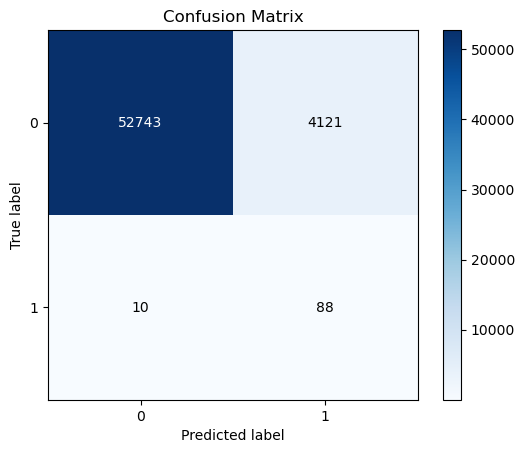

In [13]:
print(f"f1: {f1_score(y_test, y_pred)}")
print(f"accuracy: {accuracy_score(y_test, y_pred)}")
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

f1: 0.006474944033063544
accuracy: 0.4935746638109617


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

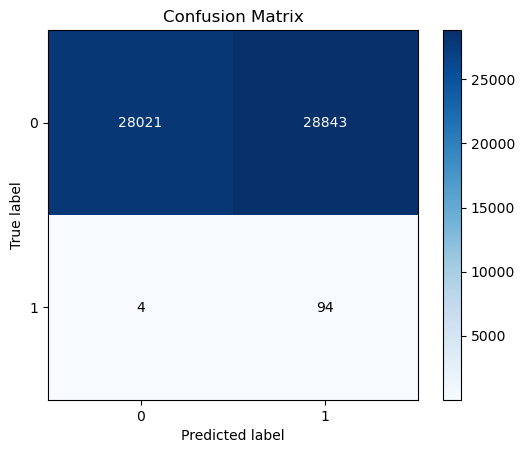

In [14]:
y_proba, y_pred = fit_model(X_train,y_train,X_test=X_test,version=2,n_neighbors_near_miss=5)
print(f"f1: {f1_score(y_test, y_pred)}")
print(f"accuracy: {accuracy_score(y_test, y_pred)}")
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

f1: 0.32245681381957775
accuracy: 0.9938028861346161


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

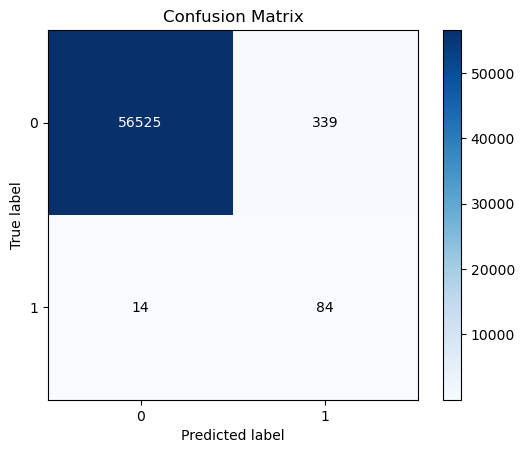

In [15]:
y_proba, y_pred = fit_model(X_train,y_train,X_test=X_test,version=3,n_neighbors_near_miss=5, sampling_strategy=0.4)
print(f"f1: {f1_score(y_test, y_pred)}")
print(f"accuracy: {accuracy_score(y_test, y_pred)}")
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

f1: 0.3640256959314775
accuracy: 0.9947859976826656


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

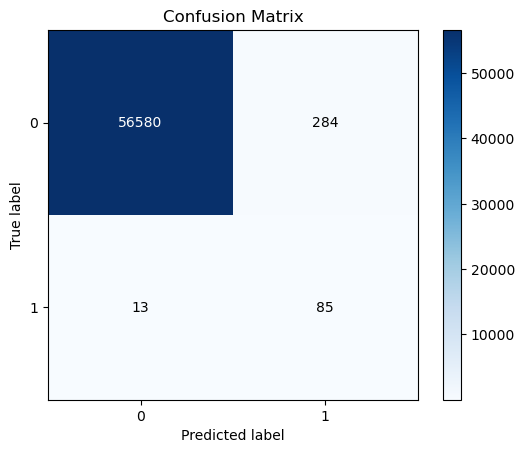

In [16]:
# we have too little values of the majority class, let us take some more values
y_proba, y_pred = fit_model(X_train,y_train,X_test=X_test,version=3,n_neighbors_near_miss=5,
                            sampling_strategy=0.4)
print(f"f1: {f1_score(y_test, y_pred)}")
print(f"accuracy: {accuracy_score(y_test, y_pred)}")
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

In [17]:
from imblearn.combine import SMOTEENN

In [18]:
def fit_model_advance(X,y,X_test=False,
             cv=3,n_jobs=-1,scoring='accuracy',
             max_depth=10,n_estimators=344,n_neighbors=5,thr=0.5,sample_weight=None ):

    # We are gonna use a cross validation now
    
    """
    best model so far is: 
    {'model__max_depth': 10,
    'model__n_estimators': 344,
    'preprocessor__numerical_transformer__imputer__n_neighbors': 5}
    
    
    """


    smote_enn = SMOTEENN(random_state=0)
    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
    numerical_col_imputed = [col for col in numerical_col if X[col].isnull().any()==True]

    categorical_col = [col for col in X.columns if str(X[col].dtypes)=='object' ]
    categorical_col_imputed = [col for col in categorical_col if X[col].isnull().any()==True]
    # n_neighbors = an integer. KNNImputer 
    numerical_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", KNNImputer(n_neighbors=n_neighbors))
          ]
    )

    categorical_transformer =  Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col_imputed),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    # Define model
    model = RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators ,random_state=0,n_jobs=n_jobs)

    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[("over_under_sampling", smote_enn),
                            ('preprocessor', preprocessor),
                          ('model', model)
                         ])
   
    # this fit the pipeline to a specific model, giving an specific traning set (notice that the cross-val does not do that)
   
    pipe.fit(X,y,model__sample_weight=sample_weight)
    y_pred = pipe.predict(X_test)
    y_proba = None
    try:
        # X_test = False this will not run and it is ok
        y_proba = pipe.predict_proba(X_test)
    except:
        pass
    
    return y_proba, y_pred

f1: 0.680327868852459
accuracy: 0.9986306660580738


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

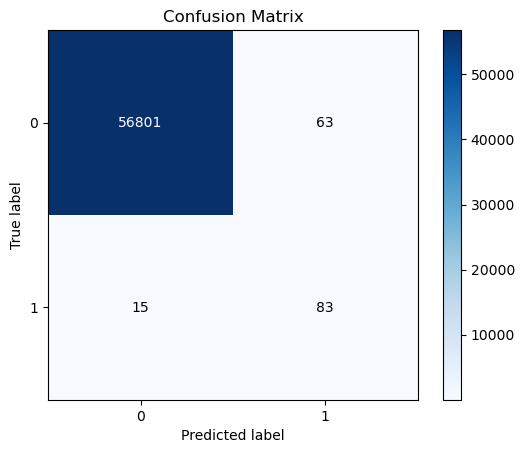

In [19]:
# we have too little values of the majority class, let us take some more values
y_proba, y_pred = fit_model_advance(X_train,y_train,X_test=X_test)
print(f"f1: {f1_score(y_test, y_pred)}")
print(f"accuracy: {accuracy_score(y_test, y_pred)}")
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

Even though we got a much better results than the previous models, we haven't get the best results overall. It is good to remember how the random forest works, because it used bagging methods and create various decision trees with 